# UdepLog Neural-Logical Inference System

## 1. Visualization

In [1]:
import os
from nltk.tree import Tree
from nltk.draw import TreeWidget
from nltk.draw.util import CanvasFrame
from IPython.display import Image, display

def jupyter_draw_nltk_tree(tree):
    cf = CanvasFrame()
    tc = TreeWidget(cf.canvas(), tree)
    tc['node_font'] = 'arial 14 bold'
    tc['leaf_font'] = 'ar|ial 14'
    tc['node_color'] = '#005990'
    tc['leaf_color'] = '#3F8F57'
    tc['line_color'] = '#175252'
    cf.add_widget(tc, 20, 20)
    os.system('rm -rf ../data/tree.png')
    os.system('rm -rf ../data/tree.ps')
    cf.print_to_file('../data/tree.ps')
    cf.destroy()
    os.system('convert ../data/tree.ps ../data/tree.png')
    display(Image(filename='../data/tree.png'))

## 2. BERT Model for Pharaphrase

In [4]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

roberta_MRPC = "textattack/roberta-base-MRPC"
bert_MRPC = "bert-base-cased-finetuned-mrpc"
albert_MRPC = "textattack/albert-base-v2-MRPC"

paraphraseTokenizer = AutoTokenizer.from_pretrained(albert_MRPC)  
paraphraseModel = AutoModelForSequenceClassification.from_pretrained(albert_MRPC)
paraphraseModel.to('cuda')
print("Load Alignment Model")

Load Alignment Model


In [5]:
bert_STS = "bert-base-uncased-STS-B"

## 3. UD Parser and RoBERTa Semantic Similarity

In [6]:
import json
from wordnet import *
from copy import deepcopy
from Udep2Mono.util import det_mark, det_type
from Udep2Mono.util import btree2list
from Udep2Mono.dependency_parse import tokenizer
from Udep2Mono.dependency_parse import dependency_parse
from Udep2Mono.binarization import BinaryDependencyTree
from Udep2Mono.polarization import PolarizationPipeline

2021-04-06 13:58:01 INFO: Loading these models for language: en (English):
| Processor | Package                  |
----------------------------------------
| tokenize  | ../model/e...ize/gum.pt  |
| pos       | ../model/en/pos/ewt.pt   |
| lemma     | ../model/en/lemma/gum.pt |
| depparse  | ../model/e...rse/gum.pt  |

2021-04-06 13:58:01 INFO: Use device: gpu
2021-04-06 13:58:01 INFO: Loading: tokenize
2021-04-06 13:58:01 INFO: Loading: pos
2021-04-06 13:58:02 INFO: Loading: lemma
2021-04-06 13:58:02 INFO: Loading: depparse
2021-04-06 13:58:03 INFO: Done loading processors!
2021-04-06 13:58:03 INFO: Loading these models for language: en (English):
| Processor | Package                 |
---------------------------------------
| tokenize  | ../model/e...ize/gum.pt |

2021-04-06 13:58:03 INFO: Use device: cpu
2021-04-06 13:58:03 INFO: Loading: tokenize
2021-04-06 13:58:03 INFO: Done loading processors!


In [7]:
import torch
from sentence_transformers import SentenceTransformer, util
sentenceTransformer = SentenceTransformer("stsb-bert-large")
sentenceTransformer.to('cuda')
from nltk.corpus import stopwords
ign_words = dict()
for word in stopwords.words('english'):
    ign_words[word] = 1

def inference_sts(seq1s, seq2s, dist=False):
    embeddings1 = sentenceTransformer.encode(seq1s, convert_to_tensor=True)
    embeddings2 = sentenceTransformer.encode(seq2s, convert_to_tensor=True)
    cosine_scores = util.pytorch_cos_sim(embeddings1, embeddings2)
    distance = torch.dist(embeddings1, embeddings2, p=2)
    if dist:
        return distance
    return cosine_scores[0][0]

## 4. Phrasal Monotonicity Inference

In [8]:
from pattern.en import pluralize, singularize
from copy import copy
import re
import torch

class PhrasalGenerator:
    def __init__(self):
        self.deptree = None
        self.annotated = None
        self.original = None
        self.kb = {}
        self.hypothesis = ""
        self.tree_log = []
        self.sent_log = []
        self.stop_critarion = False
        self.mod_at_left = [
            "advmod", "amod", "advmod:count", 
            "acl:relcl", "obl", 'obl:npmod', "det",
            "obl:tmod", "nmod", "nmod:npmod", 
            "nmod:poss", "nmod:tmod", "obl:npmod",
            "acl", "advcl", "xcomp", "ccomp", 
            'compound:ptr']
        self.mod_at_right = ["appos"] #"obj"
        self.mod_symmetric = ["conj", "compound"]
        self.mod_special = ["nsubj"]
        self.implicative = {
            "watching": 1
        }
        
        '''  
            "cop": self.generate_inherite, 
            "expl": self.generate_expl,
            "nummod": self.generate_nummod,
        '''

    def deptree_generate(self, tree, annotated, original):
        self.stop_critarion = False
        self.tree_log = []
        self.sent_log = []
        self.deptree = tree.copy()
        self.original = original  
        self.annotated = deepcopy(annotated)
        self.sentence = original
        self.generate(self.deptree)

    def generate(self, tree):
        if self.stop_critarion:
            return
        if not tree.is_tree:
            self.generate_default(tree)
        else:
            generation = self.get_generation_type(tree)
            #print(generation, tree.val)
            generation(tree)
    def removeGroup(self, tree):
        if(tree.val == "nmod"):
            if(tree.right.is_tree and tree.right.left.val.lower() == "a"):
                if(tree.left.is_tree and tree.left.left.val.lower() == "of"):
                    noun = tree.left.right
                    group = tree.right.right
                    self.delete_modifier(tree, noun)
                    self.delete_modifier(tree, group)
                    return True
        return False
    def get_generation_type(self, tree):
        if tree.val in self.mod_special:
            return self.generate_special

        disjunction = False
        if tree.val == "conj":
            disjunction |= self.search_dependency('or', tree.left)
            disjunction |= self.search_dependency('and', tree.left)
        
        left_mod = tree.left.mark == "+"
        left_mod = left_mod or tree.left.mark == "=" or disjunction
        left_mod = left_mod and tree.val in self.mod_at_left

        right_mod = tree.right.mark == "+" or tree.right.mark == "=" or disjunction 
        right_mod = right_mod and tree.val in self.mod_at_right

        sym_mod = tree.val in self.mod_symmetric and tree.left.mark == "+" and tree.right.mark == "+"
        
        if left_mod:
            return self.left_modifier_generate
        elif right_mod:
            return self.right_modifier_generate
        elif sym_mod:
            return self.symmetric_generate
        else:
            return self.generate_default

    def generate_special(self, tree):
        if tree.val == "nsubj":
            if tree.left.val == "who" and tree.right.val == "aux":
                self.left_modifier_generate(tree)

        self.generate(tree.left)
        self.generate(tree.right)

    def delete_cc(self, tree):
        if tree.val == "cc" and tree.left.val != "but":
            self.delete_modifier(tree, tree.right)

        if tree.is_tree:
            self.delete_cc(tree.left)
            self.delete_cc(tree.right)

    def delete_modifier(self, tree, modifier):
        tree.val = modifier.val
        tree.mark = modifier.mark
        tree.pos = modifier.pos
        tree.id = modifier.id
        
        tree.is_tree = modifier.is_tree
        tree.is_root = modifier.is_root

        tree.left = modifier.left
        tree.right = modifier.right

        self.delete_cc(tree)
        self.save_tree()

    def delete_left_modifier(self, tree):
        #print("Delet: ", tree.left.val)
        group = self.removeGroup(tree)
        if(not group):
            self.delete_modifier(tree, tree.right)

    def delete_right_modifier(self, tree):
        #print("Delet: ", tree.right.val)
        self.delete_modifier(tree, tree.left)

    def rollback(self, tree, backup):
        tree.val = backup.val
        tree.left = deepcopy(backup.left)
        tree.right = deepcopy(backup.right)
        tree.mark = backup.mark
        tree.pos = backup.pos
        tree.id = backup.id
        tree.is_tree = backup.is_tree
        tree.is_root = backup.is_root

    def symmetric_generate(self, tree):
        self.right_modifier_generate(tree)
        self.left_modifier_generate(tree)
        #self.delete_cc(tree)

    def right_modifier_generate(self, tree):
        left = tree.left
        right = tree.right
        backup = deepcopy(tree)

        self.delete_right_modifier(tree)
        self.save_tree()
        self.rollback(tree, backup)    
        
        self.generate(tree.left)
        self.generate(tree.right)

    def left_modifier_generate(self, tree):
        left = tree.left
        right = tree.right
        backup = deepcopy(tree)

        self.delete_left_modifier(tree)
        self.save_tree()
        self.rollback(tree, backup)   

        self.generate(tree.left)
        self.generate(tree.right)
    
    def return_last_leaf(self, tree):
        max_id = 0
        max_id_l = 0
        max_id_r = 0

        if tree.id != None:
            max_id = int(tree.id)
    
        if tree.left.is_tree:
            max_id_l = self.return_last_leaf(tree.left)
        else:
            max_id_l = tree.left.id

        if tree.right.is_tree:
            max_id_r = self.return_last_leaf(tree.right)
        else:
            max_id_r = tree.right.id

        return max(max_id, max(max_id_l, max_id_r))

    def return_first_leaf(self, tree):
        min_id = 100
        min_id_l = 100
        min_id_r = 100

        if tree.id != None:
            min_id = int(tree.id)
    
        if tree.left.is_tree:
            min_id_l = self.return_last_leaf(tree.left)
        else:
            min_id_l = tree.left.id

        if tree.right.is_tree:
            min_id_r = self.return_last_leaf(tree.right)
        else:
            min_id_r = tree.right.id

        return min(min_id, min(min_id_l, min_id_r))

    def add_modifier_sent(self, tree, modifier, direct=0): 
        sentence = deepcopy(self.sentence)
        if direct == 0:
            last_leaf = self.return_first_leaf(tree)
            sentence.insert(last_leaf-1, modifier)
        elif direct == 1:
            last_leaf = self.return_last_leaf(tree)
            sentence.insert(last_leaf, modifier)        

        self.remove_adjcent_duplicate(sentence)
        sentence = ' '.join(sentence)
        sentence = sentence.replace("-", " ")
        sentence = sentence.replace(" 's", "'s")

        if abs(len(sentence) - len(self.hypothesis)) < 15:
            re.sub(r'((\b\w+\b.{1,2}\w+\b)+).+\1', r'\1', sentence, flags = re.I)
            sentence = sentence.strip() 
            
            if sentence.lower() == self.hypothesis.lower():
                self.stop_critarion = True
                self.sent_log.append((sentence, 0.0))
                return
                
            similarity = inference_sts(sentence, self.hypothesis, dist=True)
            self.sent_log.append((sentence, similarity))

            if similarity < 0.5:
                self.sent_log.append((sentence, similarity))
                self.stop_critarion = True

    def add_modifier_lexical(self, tree, modifier, head, word_id, direct=0):
        if direct == 0:
            generated = ' '. join([modifier, head])
        else:
            generated = ' '. join([head, modifier])
        
        sentence = deepcopy(self.sentence)
        diff = 0
        if word_id > len(sentence):
            diff = word_id - len(sentence)

        goal = word_id-1-diff
        sentence[goal] = "DEL"
        sentence[goal:goal] = generated.split(' ')

        if abs(len(sentence) - len(self.hypothesis.split(' '))) < 7:
            self.remove_adjcent_duplicate(sentence)
            sentence = ' '.join(sentence)
            sentence = sentence.replace("DEL ", "")
            sentence = sentence.replace("DEL", "")
            sentence = sentence.replace("-", " ")
            sentence = sentence.replace(" 's", "'s")
            re.sub(r'((\b\w+\b.{1,2}\w+\b)+).+\1', r'\1', sentence, flags = re.I)
            sentence = sentence.strip()

            if sentence.lower() == self.hypothesis.lower():
                self.stop_critarion = True
                self.sent_log.append((sentence, 0.0))
                return
            
            similarity = inference_sts(sentence, self.hypothesis, dist=True)
            self.sent_log.append((sentence, similarity))

            if similarity < 0.5:
                self.sent_log.append((sentence, similarity))
                self.stop_critarion = True

    def generate_default(self, tree):
        VP_rel = {
            "aux":1, 
            "obj":1, 
            "obl":1, 
            "xcomp":1, 
            "ccomp":1,
            "aux:pass":1, 
            "obl:tmod":1, 
            "obl:npmod":1
        }

        VP_mod = {
            "advcl":1, 
            "xcomp":1, 
            "ccomp":1,
            "obj":1, 
            "advmod":1, 
            "obl":1, 
            "obl:tmod":1,
            "obl:nmod":1, 
            "parataxis":1, 
            "conj":1
        }

        NP_rel = {
            "amod":1,
            "compound":1,
            "det":1,
            "mark":1,
            "nmod:poss":1,
            "flat":1,
            "acl:relcl":1,
            "acl":1,
            "nmod":1
        }

        NP_mod = {
            "amod":1,
            "compound":1,
            "det":1,
            "mark":1,
            "nmod:poss":1,
            "flat":1,
        }

        if tree.pos is not None:
            if ("NN" in tree.pos or "JJ" in tree.pos) and tree.mark == "-":
                for rel in ["amod", "compound", "det", "mark", "nmod:poss", "flat", "conj", "nummod"]:
                    if rel in self.kb:
                        for phrase in self.kb[rel]:
                            if phrase['head'] == tree.val:
                                self.add_modifier_lexical(tree, phrase['mod'], tree.val, tree.id)
                for rel in ["amod", "acl:relcl", "compound", "acl", "nmod"]:
                    if rel in self.kb:
                        for phrase in self.kb[rel]:
                            if phrase['head'] == tree.val:
                                self.add_modifier_lexical(tree, phrase['mod'], tree.val, tree.id, 1)
                
            elif "VB" in tree.pos and tree.mark == "-":
                for rel in ["advmod"]:
                    if rel in self.kb:
                        for phrase in self.kb[rel]:
                            self.add_modifier_lexical(tree, phrase['mod'], tree.val, tree.id)
                            self.add_modifier_lexical(tree, phrase['mod'], tree.val, tree.id, 1)

        elif VP_rel.get(tree.val, 0) and tree.mark == "-":
            for rel in VP_mod:
                if rel in self.kb:
                    for phrase in self.kb[rel]:
                        self.add_modifier_sent(tree, phrase['mod'], direct=1)

        elif NP_rel.get(tree.val, 0) and tree.mark == "-":
            for rel in NP_mod:
                if rel in self.kb:
                    for phrase in self.kb[rel]:
                        self.add_modifier_sent(tree, phrase['mod'], direct=0)
        
        if VP_rel.get(tree.val, 0) and tree.right.val == "watching":
            self.save_tree(tree=tree.left)
        if tree.is_tree:
            self.generate(tree.left)
            self.generate(tree.right)  

    def save_tree(self, tree=None):
        if tree is None:
            leaves = self.deptree.sorted_leaves().popkeys()
            tree_copy = self.deptree.copy()
        else:
            leaves = tree.sorted_leaves().popkeys()
            tree_copy = tree.copy()
        
        sentence = ' '.join([x[0] for x in leaves])
        sentence = sentence.replace("-", " ")
        if sentence.lower() == self.hypothesis.lower():
            self.tree_log = []
            self.stop_critarion = True
            self.tree_log.append((tree_copy, sentence, 0.0))
            return
        
        similarity = inference_sts(sentence, self.hypothesis, dist=True)
        self.tree_log.append((tree_copy, sentence, similarity))

        if similarity < 0.5:
            self.tree_log = []
            self.tree_log.append((tree_copy, sentence, similarity))
            self.stop_critarion = True
    
    def remove_adjcent_duplicate(self, string):
        to_remove = -1
        for i in range(len(string)-1):
            if string[i] == string[i+1]:
                to_remove = i
        if to_remove > -1:
            del string[to_remove]

    def search_dependency(self, deprel, tree):
        if tree.val == deprel:
            return True
        else:
            right = tree.right
            left = tree.left

            left_found = False
            right_found = False

            if right is not None:
                right_found = self.search_dependency(deprel, right)

            if left is not None:
                left_found = self.search_dependency(deprel, left)

            return left_found or right_found
    
    def Diff(self, li1, li2):
        return (list(list(set(li1)-set(li2)) + list(set(li2)-set(li1))))    
    
    def preprocess(self, sentence):
        preprocessed = sentence.replace(".", "").replace("!", "").replace("?", "")
        preprocessed = preprocessed.replace("can't", "can not")
        preprocessed = preprocessed.replace("couldn't", "could not")
        preprocessed = preprocessed.replace("don't", "do not")
        preprocessed = preprocessed.replace("doesn't", "does not")
        preprocessed = preprocessed.replace("isn't", "is not")
        preprocessed = preprocessed.replace("won't", "will not")
        preprocessed = preprocessed.replace("wasn't", "was not")
        preprocessed = preprocessed.replace("weren't", "were not")
        preprocessed = preprocessed.replace("didn't", "did not")
        preprocessed = preprocessed.replace("aren't", "are not")
        preprocessed = preprocessed.replace("it's", "it is")
        preprocessed = preprocessed.replace("wouldn't", "would not")
        preprocessed = preprocessed.replace("There's", "There is")
        return preprocessed

In [9]:
modifier_relation = {
    "NN": ["amod", "nmod", "acl:relcl", "fixed", "compound", "det", "nmod:poss", "conj", "nummod"],
    "VB": ["advmod", "acl", "obl", "xcomp", "advcl", "obl:tmod", "parataxis", "obj","ccomp"]
}

def down_right(tree):
    if(tree.right == None):
        return tree
    return down_right(tree.right)

def down_left(tree):
    if(tree.left == None):
        return tree
    return down_left(tree.left)

def collect_modifiers(tree, sent_set, mod_type="NN"):
    leaves = []
    if tree.is_tree:
        if tree.val in ["mark", "case", "compound", "flat", "nmod"]:
            leaves.append(
                (list(tree.right.sorted_leaves().popkeys()),
                down_right(tree.left).val)
            )
        if tree.val in modifier_relation[mod_type]:
            leaves.append(
                (list(tree.left.sorted_leaves().popkeys()),
                down_right(tree.right).val)
            )

        for leave in leaves:
            if len(leave) > 0 and len(leave) < 10:
                head = leave[1]
                modifier = ' '.join([x[0] for x in leave[0]])
                if tree.val in sent_set:
                    sent_set[tree.val].append({'head': head,'mod': modifier})
                else:
                    sent_set[tree.val] = [{'head': head,'mod': modifier}]
        
        collect_modifiers(tree.left, sent_set, mod_type)
        collect_modifiers(tree.right, sent_set, mod_type)



Init Premise: A man with a helmet painted red is riding a blue motorcycle down the road

Hypothesis: A man with a helmet is riding a blue motorcycle down the road
{   'amod': [{'head': 'motorcycle', 'mod': 'blue'}],
    'case': [   {'head': 'with', 'mod': 'a helmet'},
                {'head': 'down', 'mod': 'the road'},
                {'head': 'with', 'mod': 'a helmet'},
                {'head': 'down', 'mod': 'the road'}],
    'det': [   {'head': 'helmet', 'mod': 'a'},
               {'head': 'man', 'mod': 'A'},
               {'head': 'road', 'mod': 'the'},
               {'head': 'motorcycle', 'mod': 'a'}],
    'nmod': [   {'head': 'helmet', 'mod': 'A man'},
                {'head': 'man', 'mod': 'with a helmet'},
                {'head': 'helmet', 'mod': 'A man'}],
    'obj': [{'head': 'riding', 'mod': 'a blue motorcycle'}],
    'obl': [{'head': 'riding', 'mod': 'down the road'}]}


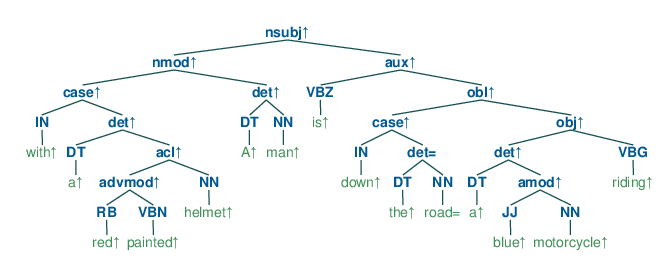

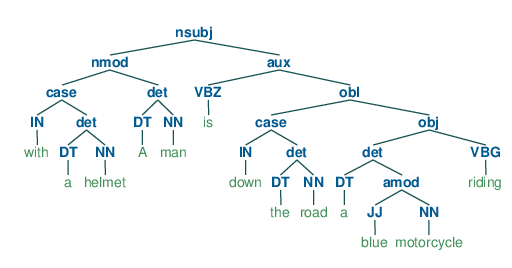

('A man with a helmet is riding a blue motorcycle down the road', 0.0)

True


In [35]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

up = ["A man with a helmet painted red is riding a blue motorcycle down the road"]
up_h = ["A man with a helmet is riding a blue motorcycle down the road"]

annotations = []
phrasalGenerator = PhrasalGenerator()
pipeline = PolarizationPipeline(verbose=0)
for i in range(len(up)):
    premise = up[i]
    hypothesis = up_h[i]
    premise = phrasalGenerator.preprocess(premise)
    hypothesis = phrasalGenerator.preprocess(hypothesis)

    tokenized = tokenizer(premise).sentences[0].words
    tokens = [tok.text for tok in tokenized]

    print("\n====================================")
    print("\nInit Premise: " + premise)
    print("\nHypothesis: " + hypothesis)

    h_parsed, replaced = dependency_parse(hypothesis, parser="stanza")
    h_tree, _ = pipeline.run_binarization(h_parsed, hypothesis, {})
    pipeline.modify_replacement(h_tree, replaced)
    phrases = {} 
    collect_modifiers(h_tree, phrases, mod_type="NN")
    collect_modifiers(h_tree, phrases, mod_type="VB")
    annotation = pipeline.single_polarization(premise)
    
    phrasalGenerator.kb = phrases
    phrasalGenerator.hypothesis = hypothesis.replace(',', '')
    pp.pprint(phrasalGenerator.kb)
    
    polarized = pipeline.postprocess(annotation['polarized_tree'], {})
    btreeViz = Tree.fromstring(polarized.replace('[', '(').replace(']', ')'))
    jupyter_draw_nltk_tree(btreeViz) 

    polarized = pipeline.postprocess(h_tree, {})
    btreeViz = Tree.fromstring(polarized.replace('[', '(').replace(']', ')'))
    jupyter_draw_nltk_tree(btreeViz)
    
    phrasalGenerator.deptree_generate(
        annotation['polarized_tree'], 
        annotation['annotated'], tokens)

    for gen_tree in phrasalGenerator.tree_log:
        #leaves = gen_tree[0].sorted_leaves().popkeys()
        #sentence = ' '.join([x[0] for x in leaves])
        print((gen_tree[1], gen_tree[2]))

    print(*phrasalGenerator.sent_log, sep="\n")
    print(phrasalGenerator.stop_critarion)

## 5. Lexical Monotonicity Inference

In [45]:
from nltk.stem import WordNetLemmatizer 

import wordnet
import importlib
importlib.reload(wordnet)

import spacy
nlp = spacy.load('en_core_web_sm')

def lemmatize(word):
    doc = nlp(word)
    for token in doc:
        return token.lemma_
    
class LexicalGenerator:
    def __init__(self):
        self.deptree = None
        self.premise = ""
        self.hypothesis = ""
        self.tree_log = []
        self.ant_ht = {}
        self.sentence_base = set()
        self.anti_tree_log = []
        self.polar_log = []
        self.replacement_log = []
        self.stop_critarion = False
        self.key_tokens = [
            'NN','NNS','NNP','NNPS','VBD',
            'VBG','VBN','VBZ','VB',"JJ"]
        self.absolute = False
        self.propers = ["someone", "something", "somewhere"]
        self.memory = {}
        self.nondetermine = False
        self.quantifiers = {}
        self.lemmatizer = WordNetLemmatizer() 
        with open('quantifier.json', 'r') as quants:
            quantifier_data = json.load(quants)
            for quantifier in quantifier_data:
                self.quantifiers[quantifier['word']] = quantifier

    def absolute_generate(self, src, dest):
        #mono = list(zip(*annotation))[2]
        self.nondetermine = False
        hyper, hypo, syn, ant, _ = wordnet.get_word_sets(
            lemmatize(src))
        
        self.ant_ht = {**self.ant_ht, **ant}
        _, _, syn_multi, _, _ = wordnet.get_word_sets(src)
        syn_full = {**syn, **syn_multi} 
        if src == "boy" or src == "girl":
            if "young" in syn_full:
                syn_full["young"] = 0
        self.memory[src] = (hyper, hypo, syn_full, ant)
        if src == "boy":
            ant['chick'] = 1 
        if src == "running":
            ant['stand'] = 1

        if lemmatize(dest) in ant:
            self.nondetermine = True
            return False

        #if mono[id] == "+":


    def deptree_generate(self, tree):
        self.replacement_log = []
        self.nondetermine = False
        self.sentence_base = set()
        self.tree_log = []
        self.anti_tree_log = []
        self.stop_critarion = False
        self.deptree = tree.copy()
        self.generate(self.deptree)

    def generate(self, tree):
        if tree is None or self.stop_critarion:
            return
        if tree.pos is not None and not tree.val in self.hypothesis: 
            backup = copy(tree.val)
            if tree.pos == "NNP" and tree.mark == "+":
                for word in self.propers:
                    if word in self.hypothesis_tokens:
                        tree.val = word
                        self.save_tree()
                        self.replacement_log.append(
                            "{} => {}".format(backup, word))
                        tree.val = backup

            if tree.pos in self.key_tokens:
                if tree.val in self.memory:
                    hyper, hypo, syn_full, ant = self.memory[tree.val]
                    self.ant_ht = {**self.ant_ht, **ant}
                else:
                    hyper, hypo, syn, ant, _ = wordnet.get_word_sets(
                        self.lemmatizer.lemmatize(tree.val))
                    self.ant_ht = {**self.ant_ht, **ant}
                    _, _, syn_multi, _, _ = wordnet.get_word_sets(tree.val)
                    syn_full = {**syn, **syn_multi} 
                    if tree.val == "boy" or tree.val == "girl":
                        if "young" in syn_full:
                            syn_full["young"] = 0
                    self.memory[tree.val] = (hyper, hypo, syn_full, ant)

                if tree.val == "boy":
                    self.ant_ht['chick'] = 1    

                for lex in syn_full.keys():
                    lex_ls = lex.split(' ')
                    is_eq = False
                    for key in lex_ls:
                        if ant.get(key, 0):
                            self.ant_ht[key] = 1
                            if self.absolute:
                                self.nondetermine = True
                                return False
                        if key in self.ant_ht:
                            if self.absolute:
                                self.nondetermine = True
                                return False
                            break
                        if not ign_words.get(key,0):
                            is_eq = True
                    if is_eq:
                        tree.val = lex
                        self.save_tree()
                        self.replacement_log.append(
                            "{} => {}".format(backup, lex))
                tree.val = backup

                if tree.mark == "+":
                    if tree.val == "pianist":
                        tree.val = "person"
                        self.save_tree()
                        self.replacement_log.append(
                            "{} => {}".format(backup, "person"))          
                    for lex in hyper.keys():
                        
                        lex_ls = lex.split(' ')
                        for key in lex_ls:
                            is_eq = False
                            if not ign_words.get(key,0):
                                for tok in self.hypothesis_tokens:
                                    #print(self.ant_ht)
                                    if ant.get(key, 0):
                                        self.ant_ht[key] = 1
                                        if self.absolute:
                                            self.nondetermine = True
                                            return False
                                        break
                                    if key in self.ant_ht:
                                        if self.absolute:
                                            self.nondetermine = True
                                            return False
                                        break
                                    if tok in key:
                                        is_eq = True
                                if is_eq:
                                    tree.val = lex
                                    self.save_tree()
                                    self.replacement_log.append(
                                        "{} => {}".format(backup, lex))
                    tree.val = backup

                if tree.mark == "-":
                    for lex in hypo.keys():
                        lex_ls = lex.split(' ')
                        for key in lex_ls:
                            #print(key)
                            #print(self.hypothesis_tokens)
                            if not ign_words.get(key,0):
                                for tok in self.hypothesis_tokens:
                                    if tok in key or key in tok:
                                        tree.val = tok
                                        self.save_tree()
                                        self.replacement_log.append(
                                            "{} => {}".format(backup, tok))
                    tree.val = backup
            
        elif tree.val == "det":
            backup = tree.left.val
            backup_mark = tree.right.mark
            kb = self.quantifiers.get(tree.left.val.lower(), {})
            if len(kb) > 0:

                for word in kb["="]:
                    tree.left.val = word
                    detType = det_type(tree.left.val)
                    if detType is None:
                        detType = "det:exist"
                    tree.left.mark = det_mark[detType]
                    self.save_tree()
                    self.replacement_log.append(
                        "{} => {}".format(backup, word))
                tree.left.val = backup
                tree.left.mark = backup_mark

                if tree.left.mark == "+":
                    for word in kb["<"]:
                        if word in self.hypothesis:
                            tree.left.val = word
                            detType = det_type(tree.left.val)
                            if detType is None:
                                detType = "det:exist"
                            tree.left.mark = det_mark[detType]
                            self.save_tree()
                            self.replacement_log.append(
                                "{} => {}".format(backup, word))
                    tree.left.val = backup
                    tree.left.mark = backup_mark
                
                if tree.left.mark == "-":
                    for word in kb[">"]:
                        if word in self.hypothesis:
                            tree.left.val = word
                            if detType is None:
                                detType = "det:exist"
                            tree.left.mark = det_mark[detType]
                            self.save_tree()
                            self.replacement_log.append(
                                "{} => {}".format(backup, word))
                    tree.left.val = backup
                    tree.left.mark = backup_mark

        elif tree.val == "nummod":
            backup = tree.left.val
            if tree.left.mark != "-":
                tree.left.val = "some"
                self.save_tree()
                self.replacement_log.append(
                    "{} => {}".format(backup, "some"))
                tree.left.val = backup
        
        if tree.left != "N":
            self.generate(tree.left)
        if tree.right != "N":
            self.generate(tree.right)

    def save_tree(self, entail=True):
        leaves = self.deptree.sorted_leaves().popkeys()
        tree_copy = self.deptree.copy()
     
        sentence = ' '.join([x[0] for x in leaves])
        
        if not sentence in self.sentence_base:
            self.sentence_base.add(sentence)
        else:
            return
        
        if sentence.lower() == self.hypothesis.lower():
            self.stop_critarion = True
            if entail:
                self.tree_log = []
                self.tree_log.append((tree_copy, sentence, 0.0))
            else:
                self.anti_tree_log = []
                self.anti_tree_log.append((tree_copy, sentence, 0.0))
            return
        
        similarity = inference_sts(sentence, self.hypothesis, dist=True)
        #print(sentence, similarity)
        if entail:
            self.tree_log.append((tree_copy, sentence, similarity))
        else:
            self.anti_tree_log.append((tree_copy, sentence, similarity))
        if similarity < 0.5:
            self.stop_critarion = True
            if entail:
                self.tree_log = []
                self.tree_log.append((tree_copy, sentence, similarity))
            else:
                self.anti_tree_log = []
                self.anti_tree_log.append((tree_copy, sentence, similarity))
            return

[nsubj↑  [det↑  [DT  A↑]  [NN  boy↑]]  [aux↑  [VBZ  is↑]  [obl↑  [case↑  [IN  in↑]  [det↑  [DT  a↑]  [NN  seat↑]]]  [VBG  sitting↑]]]]


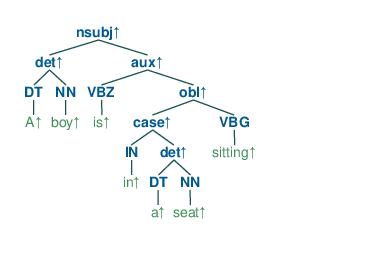

('some boy is sitting in a seat', tensor(19.7621))
('an boy is sitting in a seat', tensor(19.3686))
('one boy is sitting in a seat', tensor(20.6456))
('A male child is sitting in a seat', tensor(20.7740))
('A boy is sitting in a seat', tensor(19.3240))
('A son is sitting in a seat', tensor(21.2104))
('A brother is sitting in a seat', tensor(23.4637))
('A child is sitting in a seat', tensor(13.9254))
('A men is sitting in a seat', tensor(19.3145))
('A lad is sitting in a seat', tensor(19.3163))
('A camp is sitting in a seat', tensor(16.5167))
('A tomgirl is sitting in a seat', tensor(15.9334))
('A boyloving is sitting in a seat', tensor(21.2955))
('A shopboy is sitting in a seat', tensor(21.0751))
('A caveboy is sitting in a seat', tensor(22.0299))
('A camboy is sitting in a seat', tensor(22.2618))
('A boy is sitting in some seat', tensor(19.0991))
('A boy is sitting in an seat', tensor(19.2870))
('A boy is sitting in one seat', tensor(20.1228))
['A => some', 'A => an', 'A => one', 'boy

In [91]:
from tqdm import tqdm

sentences = ["A boy is sitting in a seat"]
hypotheses = ["A girl is sitting in a seat"]

pipeline = PolarizationPipeline(verbose=0)
lexicalGenerator = LexicalGenerator()
phrasalGenerator = PhrasalGenerator()

for premise, hypothesis in zip(sentences, hypotheses):
    premise = phrasalGenerator.preprocess(premise)
    hypothesis = phrasalGenerator.preprocess(hypothesis)

    h_parsed, replaced = dependency_parse(hypothesis, parser="stanza")
    #h_tree, _ = pipeline.run_binarization(h_parsed, hypothesis, {})
    #pipeline.modify_replacement(h_tree, replaced)
    key_tokens = set()
    for word in h_parsed[2]:
        pos = h_parsed[2][word][1]
        if 'NN' in pos or 'JJ' in pos or 'VB' in pos:
            if(not ign_words.get(h_parsed[2][word][0],0)):
                key_tokens.add(h_parsed[2][word][0])

    #print("\n====================================")
    #print("\nInit Premise: " + premise)
    #print("\nHypothesis: " + hypothesis)

    #tokenized = tokenizer(hypothesis).sentences[0].words
    #tokens = {} 
    #lemmatizer = WordNetLemmatizer() 
    #for tok in tokenized:
    #    tokens[lemmatizer.lemmatize(tok.text)] = tok.text
    lexicalGenerator.hypothesis_tokens = key_tokens

    annotation = pipeline.single_polarization(premise)
    polarized = pipeline.postprocess(annotation['polarized_tree'], {})
    print(polarized)
    btreeViz = Tree.fromstring(polarized.replace('[', '(').replace(']', ')'))
    jupyter_draw_nltk_tree(btreeViz) 

    lexicalGenerator.hypothesis = hypothesis.replace(',', '')
    lexicalGenerator.deptree_generate(annotation['polarized_tree'])
    
    for gen_tree in lexicalGenerator.tree_log:
        print((gen_tree[1], gen_tree[2]))
    for anti_tree in lexicalGenerator.anti_tree_log:
        print((anti_tree[1], anti_tree[2]))

    print(lexicalGenerator.replacement_log)
    print(lexicalGenerator.stop_critarion)

In [11]:
MED_upward = []
MED_upward_hypo = []
MED_downward = []
MED_downward_hypo = []

with open("../data/MED/upward.txt") as upward_med:
    lines = upward_med.readlines()
    for i in range(len(lines) // 4):
        MED_upward.append(lines[i*4+1])
        MED_upward_hypo.append(lines[i*4+2])

with open("../data/MED/downward.txt") as donward_med:
    lines = donward_med.readlines()
    for i in range(len(lines) // 4):
        MED_downward.append(lines[i*4+1])
        MED_downward_hypo.append(lines[i*4+2])

print(len(MED_upward))
print(len(MED_downward))

458
1738


## 6. Syntactic Variational Inference

In [11]:
import controller
import importlib
#importlib.reload(controller)

class SyntacticVariator:
    
    def __init__(self):
        self.chunker = controller.Chunker()
        self.paraphraseTokenizer = paraphraseTokenizer
        self.paraphraseModel = paraphraseModel
        self.replacement_log = []
        self.knowledge = [
            ("A man with a helmet", "A motorcyclist"),
            ("A man, a woman and two girls", "A group of people"),
            ("A man, a woman and two girls", "Four people"),
        ]

    def chunking(self, tree):
        return self.chunker.get_chunks_byDepTree(tree)

    def build_pairs(self, chunks1, chunks2):
        chunk_pairs = []
        for chunk1 in chunks1:
            for chunk2 in chunks2:
                if len(set(chunk1.split(' ')).intersection(chunk2.split(' '))) > 0:
                     chunk_pairs.append((chunk1, chunk2))

        return chunk_pairs

    def inference_mrpc(self, seq1, seq2):
        paraphrase = paraphraseTokenizer.encode_plus(
            seq1, seq2, return_tensors="pt")
        paraphrase.to('cuda')
        logits = paraphraseModel(**paraphrase)[0]
        paraphrase_results = torch.softmax(logits, dim=1).tolist()[0]
        return paraphrase_results[1]

    def phrase_alignment(self, chunk_pairs):
        alignments = []
        for pair in chunk_pairs:
            score = self.inference_mrpc(pair[0], pair[1])
            #print(pair, score)
            if score > 0.80:
                #if len(set(pair[0].split(' ')) - set(pair[1].split(' '))) > 1:
                alignments.append(pair)

        return alignments

    def check_passact(self, ie1, ie2):
        for verb in ie1:
            if 'ARG1' in verb['tags'][0] or 'ARG1' in verb['tags'][1]:
                return True

        for verb in ie2:
            if 'ARG1' in verb['tags'][0] or 'ARG1' in verb['tags'][1]:
                return True
        
        return False

    def variate(self, P, H, p_tree, h_tree, sent=False):
        self.replacement_log = []
        p_chunks = self.chunking(p_tree)
        h_chunks = self.chunking(h_tree)

        ie_pred_p = ie_extractor.predict(P)['verbs']
        ie_pred_h = ie_extractor.predict(H)['verbs']

        if self.check_passact(ie_pred_p, ie_pred_h):
            sent = True

        if sent:
            p_chunks.append(P)
            h_chunks.append(H)

        #for verb in ie_pred_p:
        #    if "ARG" in verb['description']:
        #        p_chunks.append(fix_info(verb['description'])[0].strip())
        #        p_chunks.append(verb['verb'] + ' '+ fix_info(verb['description'])[2].strip())

        #for verb in ie_pred_h:
        #    if "ARG" in verb['description']:
        #        h_chunks.append(fix_info(verb['description'])[0].strip())
        #        h_chunks.append(verb['verb'] + ' '+ fix_info(verb['description'])[2].strip())

        chunk_pairs = self.build_pairs(p_chunks, h_chunks)
        alignments = self.phrase_alignment(chunk_pairs)

        for relation in self.knowledge:
            if relation[0] in P and relation[1] in H:
                alignments.append((relation[0], relation[1]))

        variates = set()
        for align in alignments:
            #alignList1 = align[1].split(' ')
            #if(alignList1[0] == "Somebody"):
            #    alignList2 = align[0].split(' ')
            #    var_sentence = P.replace(' '.join(alignList2[1:]), ' '.join(alignList1[1:]))
            #    self.replacement_log.append(
            #            "{} => {}".format(' '.join(alignList2[1:]), ' '.join(alignList1[1:])))
            #else:
            var_sentence = P.replace(align[0], align[1])
            self.replacement_log.append(
                        "{} => {}".format(align[0], align[1]))
            
            variates.add(var_sentence)

        return variates

In [12]:
from allennlp.predictors.predictor import Predictor
import allennlp_models.structured_prediction

ie_extractor = Predictor.from_path("https://storage.googleapis.com/allennlp-public-models/openie-model.2020.03.26.tar.gz")

error loading _jsonnet (this is expected on Windows), treating C:\Users\Admin\AppData\Local\Temp\tmpt2p__kna\config.json as plain json


In [29]:
h_parsed, replaced = dependency_parse("A man with a helmet painted red is riding a blue motorcycle down the road", parser="stanza")
h_parsed[2]["root"] = ('0', 'ROOT')
#h_tree, _ = pipeline.run_binarization(h_parsed, hypothesis, {})
#pipeline.modify_replacement(h_tree, replaced)

vertices = {}
knowledge = []
edges = {}
dep_pair = {}
for rel in h_parsed[0]:
    dep_pair[rel[1]] = (rel[2], rel[0])
conj_v = []
for rel in h_parsed[0]:
    if rel[0] == "conj-vb":
        vid = rel[1]
        rel[0] = dep_pair[rel[1]][1]
        rel[1] = dep_pair[rel[1]][0]
        rel[2] = vid

    head = rel[2] #h_parsed[2][rel[2]][0] + '_' + str(rel[2])
    mod = rel[1]  #h_parsed[2][rel[1]][0] + '_' + str(rel[1])

    edges[head] = mod

    if head in vertices:
        vertices[head].append(rel)
    else: 
        vertices[head] = [rel]
        
vertices

{2: [['det', 1, 2], ['nmod', 5, 2]],
 9: [['nsubj', 2, 9], ['aux', 8, 9], ['obj', 12, 9], ['obl', 15, 9]],
 5: [['case', 3, 5], ['det', 4, 5], ['acl', 6, 5]],
 6: [['advmod', 7, 6]],
 'root': [['root', 9, 'root']],
 12: [['det', 10, 12], ['amod', 11, 12]],
 15: [['case', 13, 15], ['det', 14, 15]]}

In [30]:
from pqdict import pqdict

def extract_entity(nodes):
    word_queue = pqdict([])
    for node in nodes:
        word_queue[node[1]] = node[1]
        subnodes = vertices.get(node[1], [])
        subwords = extract_entity(subnodes)
        for word in subwords:
            word_queue[word] = subwords[word]
    return word_queue


for rel in h_parsed[0]:
    if rel[0] in ['nsubj']:
        subj_nodes = vertices.get(rel[1], []) + [rel]
        word_queue = extract_entity(subj_nodes)
        keys = list(word_queue.popkeys())
        subj = ' '.join([h_parsed[2][k][0] for k in keys])
        objs = []
        for node in vertices[rel[2]]:
            if node[0] in ['obj', 'xcomp', 'obl', 'case']:
                subnodes = vertices.get(node[1], []) + [node]
                word_queue = extract_entity(subnodes)
                keys = list(word_queue.popkeys())
                objs.append(' '.join([h_parsed[2][k][0] for k in keys]))
        knowledges = []
        relation = h_parsed[2][rel[2]][0]
        for obj in objs:
            print((subj, relation, obj))

('A man with a helmet painted red', 'riding', 'a blue motorcycle')
('A man with a helmet painted red', 'riding', 'down the road')


In [31]:
premise = "A big wave is being ridden by a surfer"
hypothesis = "The surfer is riding a big wave"

pipeline = PolarizationPipeline()
syntacticVariator = SyntacticVariator()

h_parsed, replaced = dependency_parse(hypothesis, parser="stanza")
h_tree, _ = pipeline.run_binarization(h_parsed, hypothesis, {})
pipeline.modify_replacement(h_tree, replaced)
annotation = pipeline.single_polarization(premise)

variates = syntacticVariator.variate(premise, hypothesis, annotation['polarized_tree'],  h_tree)
for v in variates:
    similarity = inference_sts(v, hypothesis, dist=True)
    print(v, similarity)
print(syntacticVariator.replacement_log)

a big wave is being ridden by a surfer tensor(5.9572)
is riding tensor(26.9629)
A big wave is riding tensor(13.5435)
is riding a big wave tensor(12.4002)
The surfer is riding a big wave tensor(0.)
A big wave is riding by a surfer tensor(6.3803)
A big wave is riding a big wave tensor(11.9246)
A big wave The surfer is riding a big wave tensor(3.4807)
A big wave is being ridden The surfer tensor(6.6682)
['is being ridden => is riding', 'is being ridden by a surfer => is riding a big wave', 'is being ridden by a surfer => is riding', 'is being ridden by a surfer => The surfer is riding a big wave', 'by a surfer => The surfer', 'A big wave => a big wave', 'A big wave is being ridden by a surfer => is riding a big wave', 'A big wave is being ridden by a surfer => is riding', 'A big wave is being ridden by a surfer => The surfer is riding a big wave']


## 8. A* Inference Search Engine

In [34]:
from pqdict import pqdict

class AStarPlanner:
    def __init__(self, verbose=0):    
        self.closed = []                  
        self.entailments = set()
        self.contradictions = set()
        self.controller = controller.Controller()
        self.hypothesis = ""
        self.h_tree = None
        self.verbose = verbose
        self.pipeline = PolarizationPipeline()
        self.phrasalGenerator = PhrasalGenerator()
        self.lexicalGenerator = LexicalGenerator()
        self.syntacticVariator = SyntacticVariator() 

    def hypothesis_kb(self):
        self.hypothesis = self.phrasalGenerator.preprocess(self.hypothesis).replace('\n', '')
        h_parsed, replaced = dependency_parse(self.hypothesis, parser="stanza")
        h_tree, _ = self.pipeline.run_binarization(h_parsed, self.hypothesis, {})
        self.pipeline.modify_replacement(h_tree, replaced)
        phrases = {} 
        collect_modifiers(h_tree, phrases, mod_type="NN")
        collect_modifiers(h_tree, phrases, mod_type="VB")
        self.phrasalGenerator.kb = phrases
        key_tokens = set()
        for word in h_parsed[2]:
            pos = h_parsed[2][word][1]
            if 'NN' in pos or 'JJ' in pos or 'VB' in pos:
                if(not ign_words.get(h_parsed[2][word][0],0)):
                    key_tokens.add(h_parsed[2][word][0])
        self.lexicalGenerator.hypothesis_tokens = key_tokens
        self.lexicalGenerator.hypothesis = self.hypothesis.replace(',','')
        self.h_tree = h_tree
        

    def generate_premises(self, start):
        self.entailments.clear()
        self.contradictions.clear()

        # Polarization from Udeo2Mono
        start = self.phrasalGenerator.preprocess(start)
        annotation = self.pipeline.single_polarization(start)

        lexical_absolute = False

        datapath = self.controller.controlPipeline(annotation['polarized_tree'], self.h_tree)
        if len(datapath) == 1 and datapath[0][0] == 0:
            lexical_absolute = True
        print("Recommand: ", datapath)
         
        # Monotonicity-based Phrasal Inference
        if not lexical_absolute:
            self.phrasalGenerator.hypothesis = self.hypothesis.replace(',', '')

            tokenized = tokenizer(start).sentences[0].words
            tokens = [tok.text for tok in tokenized]

            self.phrasalGenerator.deptree_generate(
            annotation['polarized_tree'], 
            annotation['annotated'], tokens)
            
            if self.verbose == 10:
                print("============================")
                print("Phrasal Inference")

            if self.phrasalGenerator.stop_critarion:
                return True

            for tree in self.phrasalGenerator.tree_log:
                self.entailments.add((tree[1], tree[2]))
            self.entailments |= set(self.phrasalGenerator.sent_log)

            if self.verbose == 4 or self.verbose == 10:
                print(*self.entailments, sep="\n")
            

            # Syntactic Vriation
            # Sequence Chunking and Chunk Alignment from roBERTa
            if self.verbose == 10:
                print("Syntactic Vriation")

            sent_level = False
            #print(self.current_optimal)
            if self.current_optimal < 5.0:
                sent_level = True
            variates = self.syntacticVariator.variate(
                start, 
                self.hypothesis, 
                annotation['polarized_tree'], 
                self.h_tree, sent_level)
            for v in variates:
                similarity = inference_sts(v, self.hypothesis, dist=True)
                if self.verbose == 3 or self.verbose == 10:
                    print(similarity, v)
                if similarity < 0.5:
                    return True
                self.entailments.add((v, similarity))
            if self.verbose == 2 or self.verbose == 10:
                print(self.syntacticVariator.replacement_log)

        # Monotonicity-based Lexical Inference
        if self.verbose == 10:
            print("Lexical Inference")
        
        self.lexicalGenerator.premise = start
        self.lexicalGenerator.hypothesis = self.hypothesis.replace(',', '')
        if lexical_absolute:
            #print("absoilute generation")
            self.lexicalGenerator.absolute_generate(datapath[0][3], datapath[0][4])
            if self.lexicalGenerator.nondetermine:
                return False

        self.lexicalGenerator.deptree_generate(annotation['polarized_tree'])
        
        if self.verbose == 1 or self.verbose == 10:
            print(self.lexicalGenerator.ant_ht)
            print(self.lexicalGenerator.replacement_log)
        
        if self.lexicalGenerator.stop_critarion:
            return True
        for tree in self.lexicalGenerator.tree_log:
            if self.verbose == 1 or self.verbose == 10:
                print((tree[1], tree[2]))
            self.entailments.add((tree[1], tree[2]))

        return False

    def generate(self, start, opened):
        terminate = self.generate_premises(start)
        if terminate:
            return True

        for premise in self.entailments:
            if premise in self.closed:
                continue
            cost = premise[1]
            if premise[0] not in opened:
                opened[premise[0]] = cost
            if cost < opened[premise[0]]:
                opened[premise[0]] = cost
        return False

    def search(self, premises, hypothesis):
        self.closed = pqdict({})
        self.hypothesis = hypothesis
        premises = premises.replace('\n','')

        self.hypothesis_kb()
        self.phrasalGenerator.hypothesis = self.hypothesis
        self.lexicalGenerator.hypothesis = self.hypothesis
        self.lexicalGenerator.ant_ht = {}

        open_lists = pqdict({})
        open_lists[premises] = inference_sts(premises, hypothesis, dist=True)
        self.current_optimal = open_lists[premises]

        hop = 0
        top_k = 1

        while open_lists:
            optimals = []
            for _ in range(top_k):
                if len(open_lists) > 0:
                    optimals.append(open_lists.popitem())
            
            for optimal in optimals:
                print(optimal[1], self.current_optimal)
                if optimal[1] > self.current_optimal and (optimal[1]- self.current_optimal) > 3:
                    return False
                self.current_optimal = optimal[1]
                self.closed[optimal] = len(self.closed) + 1
                #if self.verbose == 7 or self.verbose == 10:
                print("Optimal: ", optimal)
                goal_found = self.generate(optimal[0], open_lists)
                if goal_found:
                    self.closed[(self.hypothesis, 0.0)] = len(self.closed) + 1
                    return True   
            hop += 1
            if hop > 4:
                break

In [49]:
from tqdm import tqdm
entail_p = []
entail_hypo = []
neutral_p = []
neutral_hypo = []
entail_imp_P = []
entail_imp_hypo = []
neutral_imp_P = []
neutral_imp_hypo = []

with open("../data/SICk/entail.txt") as upward_med:
    lines = upward_med.readlines()
    for i in range(len(lines) // 3):
        entail_p.append(lines[i*3])
        entail_hypo.append(lines[i*3+1])

with open("../data/SICk/neutral.txt") as sick_noun:
    lines = sick_noun.readlines()
    for i in range(len(lines) // 3):
        neutral_p.append(lines[i*3])
        neutral_hypo.append(lines[i*3+1])

with open("SICK_neutral_incorrect.txt") as sick_noun:
    lines = sick_noun.readlines()
    for i in range(len(lines) // 4):
        neutral_imp_P.append(lines[i*4+1])
        neutral_imp_hypo.append(lines[i*4+2])

with open("SICK_entail_incorrect.txt") as sick_noun:
    lines = sick_noun.readlines()
    for i in range(len(lines) // 4):
        entail_imp_P.append(lines[i*4+1])
        entail_imp_hypo.append(lines[i*4+2])

#print(len(entail_p))
#2792
planner = AStarPlanner(verbose=0)

def evak_sick(premises, hypos):
    with open("./entail_imp.txt", 'w') as generate_log:
        for i in tqdm(range(len(premises))):
            premise = premises[i].replace('\n', '').replace('Premise: ', "")
            hypothesis = hypos[i].replace('\n', '').replace('Hypothesis: ', "")
            try:
                entail = planner.search(premise, hypothesis)
                if not entail:
                    #print("\nID: " + str(i))
                    generate_log.write("\nID: " + str(i))
                    generate_log.write("\nPremise: " + premise)
                    generate_log.write("\nHypothesis: " + hypothesis)
                    generate_log.write('\n')
            except:
                #continue
                generate_log.write("\nID: " + str(i))
                generate_log.write("\nPremise: " + premise)
                generate_log.write("\nHypothesis: " + hypothesis)
                generate_log.write('\n')

            #print(*planner.closed, sep=" =>\n")

evak_sick(entail_imp_P, entail_imp_hypo)

Recommand:  [[0, 2, 2, 'men', 'people'], [0, 4, 4, 'carrying', 'walking'], [2, 8, 6, 'blankets', 'laden cc baskets'], [1, 5, -1, 'colorful', None], [2, 6, 6, 'baskets', 'laden cc baskets'], [2, 13, 6, 'building', 'laden cc baskets']]
tensor(9.0657) tensor(14.3053)
Optimal:  ('Two douth are carrying colorful baskets and blankets and walking near a building', tensor(9.0657))
Recommand:  [[0, 2, 2, 'douth', 'people'], [0, 4, 4, 'carrying', 'walking'], [2, 8, 6, 'blankets', 'laden cc baskets'], [1, 5, -1, 'colorful', None], [2, 6, 6, 'baskets', 'laden cc baskets'], [2, 13, 6, 'building', 'laden cc baskets']]
 84%|████████▍ | 119/141 [33:14<04:22, 11.93s/it]tensor(7.1515) tensor(9.0657)
Optimal:  ('Two douth are carrying colorful baskets and blankets walking', tensor(7.1515))
tensor(9.4288) tensor(9.4288)
Optimal:  ('Two people are carrying colorful baskets and blankets and walking near a building', tensor(9.4288))
Recommand:  [[0, 4, 4, 'carrying', 'walking'], [2, 13, 6, 'building', 'laden

In [51]:
planner = AStarPlanner(verbose=7)
entail = planner.search(entail_imp_P[125].replace('Premise: ', ""), entail_imp_hypo[125].replace('Hypothesis: ', ""))
print(*planner.closed, sep=" =>\n")
print(entail)

tensor(23.4738) tensor(23.4738)
Optimal:  ('Two brown and white dogs are fighting on a grassy area in front of a tree', tensor(23.4738))
Recommand:  [[1, 4, -1, 'white', None], [1, 2, -1, 'brown', None], [2, 5, 2, 'dogs', 'animals'], [1, -1, 5, None, 'outside'], [2, 7, 4, 'fighting', 'playing'], [1, 11, -1, 'area', None]]
tensor(17.4863) tensor(23.4738)
Optimal:  ('Two brown and white dogs are active on a grassy area in front of a tree', tensor(17.4863))
Recommand:  [[1, 2, -1, 'brown', None], [1, 4, -1, 'white', None], [2, 5, 2, 'dogs', 'animals'], [1, -1, 5, None, 'outside'], [2, 7, 4, 'active', 'playing'], [1, 11, -1, 'area', None]]
tensor(15.4492) tensor(17.4863)
Optimal:  ('Two dogs are active on a grassy area in front of a tree', tensor(15.4492))
Recommand:  [[0, 2, 2, 'dogs', 'animals'], [1, -1, 5, None, 'outside'], [2, 4, 4, 'active', 'playing'], [1, 8, -1, 'area', None]]
tensor(13.3542) tensor(15.4492)
Optimal:  ('Two dogs are active on a area in front of a tree', tensor(13.35

In [48]:
planner = AStarPlanner(verbose=7)
entail = planner.search(entail_p[347], entail_hypo[347])
print(*planner.closed, sep=" =>\n")
print(entail)

Optimal:  ('A little girl is playing a grand piano on stage', tensor(11.0662))
Optimal:  ('A little girl is playing a imposing piano on stage', tensor(7.3023))
Optimal:  ('A little girl is playing a tremendous piano on stage', tensor(7.4375))
Optimal:  ('A little girl is playing a imposing piano on stage', tensor(6.5751))
Optimal:  ('A little girl is playing a tremendous piano on stage', tensor(6.8940))
Optimal:  ('A little girl is playing a imposing piano on stage', tensor(6.5751))
Optimal:  ('A little girl is playing a tremendous piano on stage', tensor(6.8940))
Optimal:  ('A little girl is playing a imposing piano on stage', tensor(6.5751))
Optimal:  ('A little girl is playing a tremendous piano on stage', tensor(6.8940))
Optimal:  ('A little girl is playing a imposing piano on stage', tensor(6.5751))
Optimal:  ('A little girl is playing a tremendous piano on stage', tensor(6.8940))
('A little girl is playing a grand piano on stage', tensor(11.0662)) =>
('A little girl is playing a 

In [48]:
planner = AStarPlanner(verbose=7)
entail = planner.search("A few men are playing cricket",
        "Some people are playing cricket")
print(*planner.closed, sep=" =>\n")
print(entail)

tensor(13.1200) tensor(13.1200)
Optimal:  ('A few men are playing cricket', tensor(13.1200))
Recommand:  [[0, 2, 2, 'men', 'people']]
tensor(9.9960) tensor(13.1200)
Optimal:  ('A-few person are playing cricket', tensor(9.9960))
Recommand:  [[0, 2, 2, 'person', 'people']]
tensor(5.0901) tensor(9.9960)
Optimal:  ('a person are playing cricket', tensor(5.0901))
Recommand:  [[2, 2, 2, 'person', 'people']]
tensor(3.1770) tensor(5.0901)
Optimal:  ('a people are playing cricket', tensor(3.1770))
Recommand:  [[0, 1, 1, 'a', 'Some']]
('A few men are playing cricket', tensor(13.1200)) =>
('A-few person are playing cricket', tensor(9.9960)) =>
('a person are playing cricket', tensor(5.0901)) =>
('a people are playing cricket', tensor(3.1770)) =>
('Some people are playing cricket', 0.0)
True


In [33]:
entail = planner.search("Tambourines are being played by a group of children", 
             "A group of children is playing tambourines")
print(*planner.closed, sep=" =>\n")
print(entail)

('Tambourines are being played by a group of children', tensor(0.9701)) =>
('A group of children is playing tambourines', 1.0)
True


In [20]:
entail = planner.search("A family is watching a little boy who is hitting a baseball", 
             "A child is hitting a baseball")
print(*planner.closed, sep=" =>\n")
print(entail)

('A family is watching a little boy who is hitting a baseball', tensor(0.6364)) =>
('a little boy who is hitting a baseball', tensor(0.8425)) =>
('A child is watching a little boy who is hitting a baseball', tensor(0.7762)) =>
('A child is hitting a baseball', 1.0)
True


In [19]:
entail = planner.search("You know that some life changing actions must be taken when grandma reacts with the sad emoji", "You know that some actions must be taken when grandma reacts with the sad emoji")
print(*planner.closed, sep=" =>\n")
print(entail)

('You know that some life changing actions must be taken when grandma reacts with the sad emoji', tensor(0.9259)) =>
('You know that some life actions must be taken when grandma reacts with the sad emoji', tensor(0.9658)) =>
('You know that some changing actions must be taken when grandma reacts with the sad emoji', tensor(0.9301)) =>
('You know that some actions must be taken when grandma reacts with the sad emoji', 1.0)
True


In [18]:
entail = planner.search("A black and a white dog are joyfully running on the grass", 
             "A dog, which has a black coat, and a white dog are running on the grass")
print(*planner.closed, sep=" =>\n")
print(entail)

('A black and a white dog are joyfully running on the grass', tensor(0.5195)) =>
('A black and a white dog are running on the grass', tensor(0.9441)) =>
('one black and a white dog are joyfully running on the grass', tensor(0.5451)) =>
('A dog, which has a black coat, and a white dog are running on the grass', 1.0)
True


In [17]:
entail = planner.search("A group of boys are playing with a ball, in front of a large door made of wood", 
             "The children are playing in front of a large door")
print(*planner.closed, sep=" =>\n")
print(entail)

('A group of boys are playing with a ball, in front of a large door made of wood', tensor(0.6323)) =>
('A group of boys are playing in front of a large door made of wood', tensor(0.7649)) =>
('A group of children are playing in front of a large door made of wood', tensor(0.8844)) =>
('A group of boys are playing in front of a large door', tensor(0.8521)) =>
('The children are playing in front of a large door', 1.0)
True


In [16]:
entail = planner.search("A man with a red helmet is riding a blue motorcycle down the road", 
             "A motorcyclist is riding a motorbike along a roadway")
print(*planner.closed, sep=" =>\n")
print(entail)

('A man with a red helmet is riding a blue motorcycle down the road', tensor(0.6541)) =>
('A man is riding a blue motorcycle down the road', tensor(0.7365)) =>
('A man is riding a motorbike down the road', tensor(0.9152)) =>
('A man is is riding a motorbike a motorbike down the road', tensor(0.9281)) =>
('A man is is riding motorbike a motorbike down the road', tensor(0.9314)) =>
('man is is riding a motorbike a motorbike down the road', tensor(0.9309)) =>
('A motorcyclist is riding a motorbike along a roadway', 1.0)
True


In [18]:
entail = planner.search(entail_p[52], entail_hypo[52])
#entail = planner.search("A dog that has a black and white coat is trotting through shallow water", 
#             "A dog that has a white and black colored coat is trotting through shallow water.")
print(*planner.closed, sep=" =>\n")
print(entail)

Optimal:  ('Two little boys are playing outside with a soccer ball on the green grass', tensor(0.8294))
['are playing outside with a soccer ball on the green grass => are playing outside with a soccer ball on the green grass', 'Somebody are playing outside with a soccer ball on the green grass => are playing outside with a soccer ball on the green grass', 'Somebody are playing outside with a soccer ball on the green grass => with a soccer ball on the green grass', 'playing outside with a soccer ball on the green grass => are playing outside with a soccer ball on the green grass', 'are playing outside with a soccer ball on the green grass => are playing outside with a soccer ball on the green grass', 'are playing outside with a soccer ball on the green grass => with a soccer ball on the green grass', 'on the green grass => on the green grass', 'a soccer ball on the green grass => are playing outside with a soccer ball on the green grass', 'with a soccer ball on the green grass => are pl

In [68]:
entail = planner.search("The leading car gradually shifted to the left lane", 
             "The leading car slowly shifted to the left lane")
print(*planner.closed, sep=" =>\n")
print(entail)

Optimal:  ('The leading car gradually shifted to the left lane', tensor(0.9242))
('The leading car gradually shifted to the left lane', tensor(0.9242)) =>
('The leading car slowly shifted to the left lane', 1.0)
True


In [ ]:
entail = planner.search("A family is watching a little boy who is hitting a baseball", 
             "A child is hitting a baseball")
print(*planner.closed, sep=" =>\n")
print(entail)

In [ ]:
entail = planner.search("A deer is jumping over a fence", 
             "A deer is jumping a fence")
print(*planner.closed, sep=" =>\n")
print(entail)

In [ ]:
entail = planner.search("A boy is hitting a baseball", 
             "A chil is hitting a baseball")
print(*planner.closed, sep=" =>\n")
print(entail)

In [ ]:
entail = planner.search("A brown dog is attacking another animal in front of the tall man in pants", 
             "A dog is attacking another animal in front of the man in pants")
print(*planner.closed, sep=" =>\n")
print(entail)

In [ ]:
entail = planner.search("A family is watching a little boy who is hitting a baseball", 
             "A family is watching a boy who is hitting a baseball")
print(*planner.closed, sep=" =>\n")
print(entail)

In [ ]:
entail = planner.search("You can't park in front of my house on weekends.", 
             "You can't park in front of my large house on weekends.")

print(*planner.closed, sep=" =>\n")
print(entail)

In [ ]:
from tqdm import tqdm

annotations = []
with open("./generation_log_upward.txt", 'w') as generate_log:
    phrasalGenerator = PhrasalGenerator()
    pipeline = PolarizationPipeline(verbose=0)
    for i in tqdm(range(0, 500)):
        premise = MED_none[i].replace('\n', '')
        hypothesis = MED_none_hypo[i].replace('\n', '')
        premise = phrasalGenerator.preprocess(premise)
        hypothesis = phrasalGenerator.preprocess(hypothesis)

        tokenized = tokenizer(premise).sentences[0].words
        tokens = [tok.text for tok in tokenized]

        try:
            h_parsed, replaced = dependency_parse(hypothesis, parser="stanza")
            h_tree, _ = pipeline.run_binarization(h_parsed, hypothesis, {})
        except:
            generate_log.write("\nPremise: " + premise)
            generate_log.write("\nHypothesis: " + hypothesis)
            continue
        pipeline.modify_replacement(h_tree, replaced)
        phrases = {} 
        collect_modifiers(h_tree, phrases, mod_type="NN")
        collect_modifiers(h_tree, phrases, mod_type="VB")

        try:
            annotation = pipeline.single_polarization(premise)
        except:
            #generate_log.write("\nPremise: " + premise)
            #generate_log.write("\nHypothesis: " + hypothesis)
            continue
    
        phrasalGenerator.kb = phrases
        #print(phrasalGenerator.kb)
        phrasalGenerator.hypothesis = hypothesis.replace(',', '')
        
        phrasalGenerator.deptree_generate(
            annotation['polarized_tree'], 
            annotation['annotated'], 
            tokens)

        # for gen_tree in phrasalGenerator.tree_log:
        #    leaves = gen_tree[0].sorted_leaves().popkeys()
        #    sentence = ' '.join([x[0] for x in leaves])
        #    print((sentence, gen_tree[1]))
            
        if phrasalGenerator.stop_critarion:
            generate_log.write("\nID: " + str(i))
            generate_log.write("\nPremise: " + premise)
            generate_log.write("\nHypothesis: " + hypothesis)
            #print("\nPremise: " + premise)
            #print("\nHypothesis: " + hypothesis)
            #print(*phrasalGenerator.sent_log, sep="\n")
            #generate_log.writelines(phrasalGenerator.sent_log)
            generate_log.write('\n')

In [9]:
entail_p = []
entail_hypo = []

with open("generation_log_SICK_Neutral.txt", 'r') as upward_med:
    lines = upward_med.readlines()
    for i in range(len(lines) // 4):
        entail_p.append(lines[i*4+1])
        entail_hypo.append(lines[i*4+2])

In [10]:
with open("SICK_neutral_incorrect.txt", 'w') as generate_log:
    for i in range(len(entail_p)):
        generate_log.write("ID: " + str(i) + '\n')
        generate_log.write(entail_p[i])
        generate_log.write(entail_hypo[i] + '\n')

In [69]:
import numpy as np
confusion1 = np.asarray([[435, 0,   979], 
                         [0,   598, 122], 
                         [136, 55,   2606]])

confusion2 = np.asarray([[1026, 0,   388], 
                         [0,   598,  122], 
                         [840, 55,   1902]])

confusion_full = np.asarray([[1272, 0,   142], 
                             [0,   598,  122], 
                             [142, 55,   2600]])

def precision(conf):
    p = []
    for i in range(3):
        pre = conf[i][i] / (conf[i][0] + conf[i][1] + conf[i][2])
        p.append(round(pre, 4))
    return p

def avg(lst):
    return sum(lst) / len(lst)

In [65]:
avg(precision(confusion1))

0.6899666666666665

In [66]:
avg(precision(confusion1.T))

0.7935333333333333

In [67]:
avg(precision(confusion2))

0.7454000000000001

In [68]:
avg(precision(confusion2.T))

0.7514

In [70]:
avg(precision(confusion_full))

0.8865999999999999

In [71]:
avg(precision(confusion_full.T))

0.9077333333333333